# motive: Analyse the scraped news data  

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import spacy
import syllables
import re
import numpy as np
from scipy.stats import mode, skew
import en_core_web_sm
plt.style.use("seaborn-darkgrid")

from tqdm import tqdm
tqdm.pandas()

## preprocess the scraped data

In [6]:
data = pd.read_csv(r"../data/common/bbc_toi_yahoo_merged/merged_extra_nlemma_npunc.csv")
print(data.columns)
data = data.drop_duplicates(subset=["heading"])
data = data.loc[~data.loc[:, "content"].isna()].reset_index(drop=True)
print(data.info())
data.head()

Index(['heading', 'content', 'heading_polarity', 'content_polarity'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   heading           7900 non-null   object 
 1   content           7900 non-null   object 
 2   heading_polarity  7900 non-null   float64
 3   content_polarity  7900 non-null   float64
dtypes: float64(2), object(2)
memory usage: 247.0+ KB
None


,heading,content,heading_polarity,content_polarity
0,domestic abuse: swansea man jailed for murderi...,a man has been jailed for life for battering h...,0.00,-0.081640
1,covid-19: how india failed to prevent a deadly...,"in early march, india's health minister harsh ...",-0.25,0.035661
2,"northampton blaze 'cruel blow', say firm's owners",two friends who spent 10 years building up the...,-0.60,-0.199242
3,einstein handwritten letter with equation fetc...,a letter written by albert einstein containing...,0.00,0.165000
4,florida high school alters 80 'immodest' yearb...,a florida high school is facing a backlash for...,0.16,0.043386


## raw text analysis: before preprocessing

In [7]:
def num_words(document):
    return len(document.split(" "))

def num_sentences(document):
    return len(document.split(". "))

def avg_word_len(document):
    words = document.split(" ")
    return sum([len(word) for word in words]) / len(words)

def num_chars(document):
    return len(document)

data.loc[:, "number_of_words"] = data.loc[:, "content"].progress_apply(num_words)
data.loc[:, "number_of_sentences"] = data.loc[:, "content"].progress_apply(num_sentences)
data.loc[:, "average_word_length"] = data.loc[:, "content"].progress_apply(avg_word_len)
data.loc[:, "number_of_characters"] = data.loc[:, "content"].progress_apply(num_chars)

data

100%|██████████| 7900/7900 [00:00<00:00, 607725.21it/s]


,heading,content,heading_polarity,content_polarity,number_of_words,number_of_sentences,average_word_length,number_of_characters
0,domestic abuse: swansea man jailed for murderi...,a man has been jailed for life for battering h...,0.00,-0.081640,719,28,4.742698,4128
1,covid-19: how india failed to prevent a deadly...,"in early march, india's health minister harsh ...",-0.25,0.035661,1199,63,5.106756,7321
2,"northampton blaze 'cruel blow', say firm's owners",two friends who spent 10 years building up the...,-0.60,-0.199242,306,12,5.032680,1845
3,einstein handwritten letter with equation fetc...,a letter written by albert einstein containing...,0.00,0.165000,236,11,5.254237,1475
4,florida high school alters 80 'immodest' yearb...,a florida high school is facing a backlash for...,0.16,0.043386,665,25,5.001504,3990
...,...,...,...,...,...,...,...,...
7895,"after long wait, max group sells 13% stake in ...",new delhi/mumbai: diversified max group has so...,-0.05,0.115864,892,32,4.794843,5168
7896,high court allows china's bytedance to operate...,mumbai: the bombay high court on tuesday permi...,0.16,0.059250,384,13,5.054688,2324
7897,ajay tyagi: separation of cmd roles not aimed ...,new delhi: capital markets regulator sebi chie...,0.00,0.185642,293,11,5.283276,1840
7898,"linkedin job titles: now, you can call yourse...",bengaluru: linkedin has introduced new job tit...,0.00,0.183394,393,16,5.035623,2371


## readability of the text
- Flesch ease test: 
    - 100 point scale
    - `flesch_ease_test_score =  206.835 – (1.015 x ASL) – (84.6 x ASW)`
    - larger -> more readable
- Flesch-Kincaid Grade Level score:
    - returns a 'grade'. students of this US school grade can read the text
    - `flesch_kincaid_grade = (.39 x ASL) + (11.8 x ASW) – 15.59`
    - smaller -> more readable

In [9]:
def asl(document):
    return len(document.split(" ")) / len(document.split(". "))
def asw(document):
    # number of syllables in the document / number of words in document
    num_syllables = [syllables.estimate(word) for word in document.split(" ")]
    return sum(num_syllables) / len(document.split(" "))
    
data.loc[:, "asl"] = data.loc[:, "content"].progress_apply(asl)
data.loc[:, "asw"] = data.loc[:, "content"].progress_apply(asw)

data.loc[:, "flesch_ease_test_score"] = 206.835 - (1.015 * data.loc[:, "asl"]) - (84.6 * data.loc[:, "asw"])
data.loc[:, "flesch_kincaid_grade_score"] = (.39 * data.loc[:, "asl"]) + (11.8 * data.loc[:, "asw"]) - 15.59

data.columns

100%|██████████| 7900/7900 [03:18<00:00, 39.75it/s]


Index(['heading', 'content', 'heading_polarity', 'content_polarity',
       'number_of_words', 'number_of_sentences', 'average_word_length',
       'number_of_characters', 'asl', 'asw', 'flesch_ease_test_score',
       'flesch_kincaid_grade_score'],
      dtype='object')

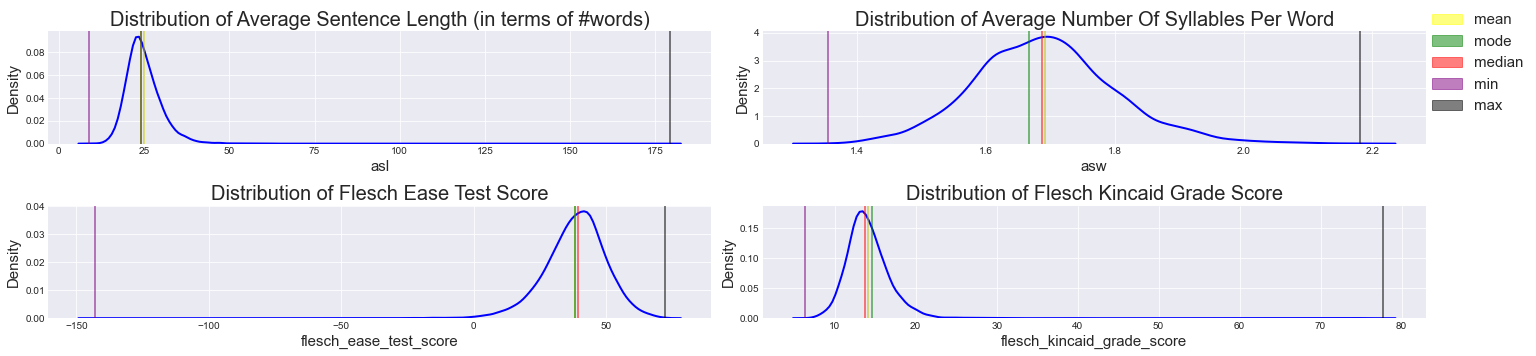

<Figure size 1440x360 with 0 Axes>

In [10]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["axes.labelsize"] = 15
cols_to_plot = ['asl', 'asw',
       'flesch_ease_test_score', 'flesch_kincaid_grade_score']
fig, axes = plt.subplots(nrows=(len(cols_to_plot) + 1) // 2, ncols=2)
for ax, cont_feat in zip(axes.flatten(), cols_to_plot):
    title = " ".join(cont_feat.split("_")).title()
    if "Asl" in title:
        title = "average sentence length".title() + " (in terms of #words)"
    elif "Asw" in title:
        title = "average number of syllables per word".title()
    ax.title.set_text("Distribution of " + title)
    ax.title.set_fontsize(20)
    sns.kdeplot(data=data, x=cont_feat, ax=ax, color="blue", linewidth=2)
    ax.axvline(np.median(data.loc[:, cont_feat]), color="r", linestyle="-", linewidth=2, alpha=0.5)
    ax.axvline(np.mean(data.loc[:, cont_feat]), color="y", linestyle="-", linewidth=2, alpha=0.5)
    ax.axvline(np.min(data.loc[:, cont_feat]), color="purple", linestyle="-", linewidth=2, alpha=0.5)
    ax.axvline(np.max(data.loc[:, cont_feat]), color="black", linestyle="-", linewidth=2, alpha=0.5)
    ax.axvline(mode(data.loc[:, cont_feat])[0][0], color="g", linestyle="-", linewidth=2, alpha=0.5)

    ax.tick_params(labelsize=10)
    
red_patch = mpatches.Patch(color='red', label='median', alpha=0.5)
yellow_patch = mpatches.Patch(color='yellow', label='mean', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='mode', alpha=0.5)
orange_patch = mpatches.Patch(color='purple', label='min', alpha=0.5)
black_patch = mpatches.Patch(color='black', label='max', alpha=0.5)
fig.legend(
    handles=[yellow_patch, green_patch, red_patch, orange_patch, black_patch],
    fontsize=15, 
    loc='upper right', 
    bbox_to_anchor=(1.07, 1.0)
)
plt.tight_layout()
plt.show()
plt.savefig('../data/bbc_text_analysis.png', dpi=300)

In [12]:
print(data.loc[data.loc[:, "flesch_ease_test_score"] == max(data.loc[:, "flesch_ease_test_score"]), "content"].values[0])

new york: alexander zverev pledged to bounce back from his bitterly disappointing loss in the final of the us open on sunday to capture a grand slam one day. the 23-year-old german went two sets and a break up in his first grand slam final before losing in five sets to austria's dominic thiem. "i was super close to being a grand slam champion. i was a few games away, maybe a few points away," a dejected zverev told reporters. "for me what upset me the most is not the third set, it's the fifth set," when he was serving for the championship at 5-3. "i had a lot of chances in the fifth set and didn't use them," he added. the second seeded thiem beat the fifth seed zverev 2-6, 4-6, 6-4, 6-3, 7-6 (8/6) in 4hr 2min. it was the first time in the us open's open era history that a player had recovered from losing the opening two sets to win the title. it was also the first time the final had been settled by a tie-break. zverev said it hurt to lose in the manner he did. "obviously being two sets

In [13]:
print(data.loc[data.loc[:, "flesch_ease_test_score"] == min(data.loc[:, "flesch_ease_test_score"]), "content"].values[0])

the best film and tv shows of the past year were celebrated at sunday's golden globe awards. here is the full list of winners: best motion picture - drama the fathermankwinner: nomadlandpromising young womanthe trial of the chicago 7 best actress in a motion picture - drama viola davis, ma rainey's black bottomwinner: andra day, the united states vs billie holidayvanessa kirby, pieces of a womanfrances mcdormand, nomadlandcarey mulligan, promising young woman best actor in a motion picture - drama riz ahmed, sound of metalwinner: chadwick boseman, ma rainey's black bottomanthony hopkins, the fathergary oldman, manktahar rahim, the mauritanian best motion picture - musical or comedy winner: borat subsequent moviefilmhamiltonmusicpalm springsthe prom best actress in a motion picture - musical or comedy maria bakalova, borat subsequent moviefilmkate hudson, music  michelle pfeiffer, french exitwinner: rosamund pike, i care a lotanya taylor-joy, emma best actor in a motion picture - musica

In [14]:
print(data.loc[data.loc[:, "flesch_kincaid_grade_score"] == max(data.loc[:, "flesch_kincaid_grade_score"]), "content"].values[0])

the best film and tv shows of the past year were celebrated at sunday's golden globe awards. here is the full list of winners: best motion picture - drama the fathermankwinner: nomadlandpromising young womanthe trial of the chicago 7 best actress in a motion picture - drama viola davis, ma rainey's black bottomwinner: andra day, the united states vs billie holidayvanessa kirby, pieces of a womanfrances mcdormand, nomadlandcarey mulligan, promising young woman best actor in a motion picture - drama riz ahmed, sound of metalwinner: chadwick boseman, ma rainey's black bottomanthony hopkins, the fathergary oldman, manktahar rahim, the mauritanian best motion picture - musical or comedy winner: borat subsequent moviefilmhamiltonmusicpalm springsthe prom best actress in a motion picture - musical or comedy maria bakalova, borat subsequent moviefilmkate hudson, music  michelle pfeiffer, french exitwinner: rosamund pike, i care a lotanya taylor-joy, emma best actor in a motion picture - musica

In [15]:
print(data.loc[data.loc[:, "flesch_kincaid_grade_score"] == min(data.loc[:, "flesch_kincaid_grade_score"]), "content"].values[0])

wwe’s saudi arabia excursion, the greatest royal rumble, features a host of dream matches and mammoth 50-man royal rumble featuring the likes of rey mysterio, the great khali, mark henry among other raw and smackdown live superstars. here are the full details of when, where and how you can catch all the action from the the greatest royal rumble in jeddah. when: the greatest royal rumble will take place on april 27, 2018, friday where: the greatest royal rumble 2018 can be viewed on the wwe network or you can follow all the live updates on times of india. you can also follow all the action on wwe.com, the wwe app, youtube, twitter, facebook, google+ and pinterest. timings: for the indian audience, the kick-off show begins at 8:30 pm and the main show will be telecasted live from 9:30 pm onwards. full match card: the historic first-ever 50-man greatest royal rumble match 2. undertaker vs. rusev (casket match) 3. universal champion brock lesnar vs. roman reigns 4. wwe champion aj styles v

In [16]:
data.to_csv("../data/bbc_toi_yahoo_stats_feats.csv", index=False)

,heading,content,heading_polarity,content_polarity,number_of_words,number_of_sentences,average_word_length,number_of_characters,asl,asw,flesch_ease_test_score,flesch_kincaid_grade_score
0,domestic abuse: swansea man jailed for murderi...,a man has been jailed for life for battering h...,0.00,-0.081640,719,28,4.742698,4128,25.678571,1.539638,50.517842,12.592376
1,covid-19: how india failed to prevent a deadly...,"in early march, india's health minister harsh ...",-0.25,0.035661,1199,63,5.106756,7321,19.031746,1.733945,40.826035,12.292931
2,"northampton blaze 'cruel blow', say firm's owners",two friends who spent 10 years building up the...,-0.60,-0.199242,306,12,5.032680,1845,25.500000,1.604575,45.205441,13.288987
3,einstein handwritten letter with equation fetc...,a letter written by albert einstein containing...,0.00,0.165000,236,11,5.254237,1475,21.454545,1.750000,37.008636,13.427273
4,florida high school alters 80 'immodest' yearb...,a florida high school is facing a backlash for...,0.16,0.043386,665,25,5.001504,3990,26.600000,1.578947,46.257053,13.415579
...,...,...,...,...,...,...,...,...,...,...,...,...
7895,"after long wait, max group sells 13% stake in ...",new delhi/mumbai: diversified max group has so...,-0.05,0.115864,892,32,4.794843,5168,27.875000,1.630045,40.640081,14.515779
7896,high court allows china's bytedance to operate...,mumbai: the bombay high court on tuesday permi...,0.16,0.059250,384,13,5.054688,2324,29.538462,1.750000,28.803462,16.580000
7897,ajay tyagi: separation of cmd roles not aimed ...,new delhi: capital markets regulator sebi chie...,0.00,0.185642,293,11,5.283276,1840,26.636364,1.870307,21.571105,16.867806
7898,"linkedin job titles: now, you can call yourse...",bengaluru: linkedin has introduced new job tit...,0.00,0.183394,393,16,5.035623,2371,24.562500,1.727735,35.737650,14.376652


## numerically find the skewness in the variables

In [19]:
for feat in ['asl', 'asw', 'flesch_ease_test_score', 'flesch_kincaid_grade_score']:
    print(feat, skew(data.loc[:, feat]))

asl 8.378806149167511
asw 0.3416457794147629
flesch_ease_test_score -2.0584414961096615
flesch_kincaid_grade_score 5.615759827415092


## tf-idf vectors of the `raw_text_lemma`

In [4]:
data.loc[3, "raw_text_lemma"].replace(" '", "")

'a letter write by Albert Einstein contain -PRON- e = mc² equation have sell at auction in the US for more than $ 1.2 m ( £ 850,000 ) - three time more than have be expect . expert say there be only three other know example of the equation in the physicists handwriting . the equation be first publish in a scientific paper by Einstein in 1905 . -PRON- explain the interchangeability of energy and mass . the equation - energy equal mass time the speed of light square - be a fundamental concept in modern physics . the man who make Einstein world - famousNew Einstein manuscript unveil this be the only example of the equation in a private collection and only become public recently , say Boston - base RR Auction , which sell the letter . " [ -PRON- be ] an important letter from both a holographic and a physics point of view , " RR Auction say in a statement , call -PRON- " the most well - know equation ever set forth " . the one - page letter in German be date 26 October 1946 and address to p

In [13]:
sum([0.33, 0.2, 0.1, 0.1, 0.08, 0.07, 0.06, 0.06])

1.0